В этом проекте мы исследуем поведение пользователей мобильного приложения стартапа, который продаёт продукты питания. Целью исследования является изучение воронки продаж и выяснение, как пользователи доходят до покупки. Мы также будем исследовать результаты A/A/B-эксперимента, чтобы определить, какой шрифт лучше для приложения. Для проведения исследования у нас есть данные о действиях пользователей в приложении, включая название события, уникальный идентификатор пользователя, время события и номер эксперимента.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from scipy import stats as st
import numpy as np

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
print(df.head())
print(df.info())

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


## Шаг 2. Подготовьте данные

**Замените названия столбцов на удобные для вас;**

In [3]:
# Заменяем названия столбцов в DataFrame
df = df.rename(columns={
    'EventName': 'event_name',      # Заменяем 'EventName' на 'event_name'
    'DeviceIDHash': 'device_id',    # Заменяем 'DeviceIDHash' на 'device_id'
    'EventTimestamp': 'event_timestamp',  # Заменяем 'EventTimestamp' на 'event_timestamp'
    'ExpId': 'exp_id'               # Заменяем 'ExpId' на 'exp_id'
})

# Выводим первые 5 строк обновленных данных
print(df.head())

                event_name            device_id  event_timestamp  exp_id
0         MainScreenAppear  4575588528974610257       1564029816     246
1         MainScreenAppear  7416695313311560658       1564053102     246
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248
3         CartScreenAppear  3518123091307005509       1564054127     248
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248


**Проверьте пропуски и типы данных. Откорректируйте, если нужно;**

In [4]:
# Выводим общую информацию о данных, включая типы данных и количество непустых значений в каждом столбце
print(df.info())

# Проверяем наличие пропусков в данных
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64


Наши данные не имеют пропусков и типы данных выглядят правильными. Все столбцы имеют 244126 непустых значений, и типы данных в столбцах device_id, event_timestamp и exp_id - это int64, а тип данных в столбце event_name - это object

**Добавьте столбец даты и времени, а также отдельный столбец дат;**

In [5]:
# Преобразуем столбец event_timestamp в формат datetime
df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')

# Добавляем столбец с датой
df['event_date'] = df['event_datetime'].dt.date

# Проверяем наличие дубликатов в данных
print(df.duplicated().sum())

# Удаляем дубликаты из данных
df = df.drop_duplicates()

413


## Шаг 3. Изучите и проверьте данные

**Сколько всего событий в логе?**

In [6]:
# Получаем общее количество событий в логе с помощью метода count
event_count = df['event_name'].count()
print(f'Общее количество событий в логе: {event_count}')

Общее количество событий в логе: 243713


**Сколько в среднем событий приходится на пользователя?**

In [7]:
# Получаем количество уникальных пользователей в логе
user_count = df['device_id'].nunique()

# Вычисляем среднее количество событий на пользователя
avg_events_per_user = event_count / user_count
print(f'Среднее количество событий на пользователя: {avg_events_per_user:.2f}')

Среднее количество событий на пользователя: 32.28


**Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?**

In [8]:
# Получаем минимальную и максимальную дату в данных
min_date = df['event_date'].min()
max_date = df['event_date'].max()

# Выводим минимальную и максимальную дату
print(f'Данные за период с {min_date} по {max_date}')

Данные за период с 2019-07-25 по 2019-08-07


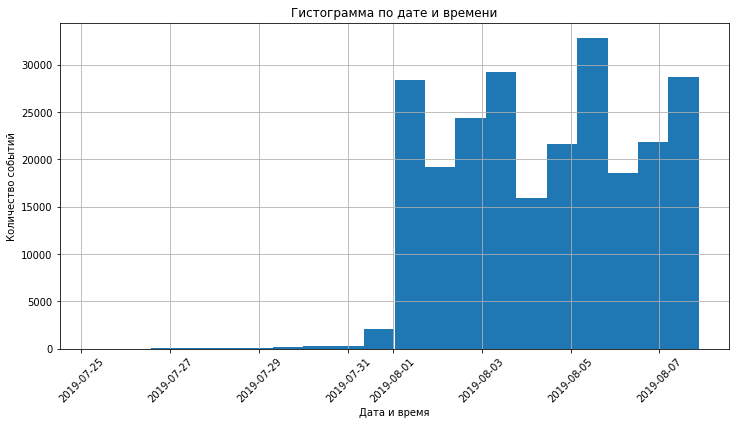

In [9]:
# Строим гистограмму по дате и времени
df['event_datetime'].hist(bins=20)

# Добавляем заголовок и подписи осей
plt.title('Гистограмма по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')

# Поворачиваем подписи на оси X
plt.xticks(rotation=45)

# Увеличиваем размер графика
plt.gcf().set_size_inches(12, 6)

In [10]:
# Определим, с какого момента данные полные и отбросим более старые.
start_date = '2019-08-01'
start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
df = df.loc[df['event_date'] >= start_date]
min_date = df['event_date'].min()
max_date = df['event_date'].max()
print(f'Полные данные за период с {min_date} по {max_date}')


Полные данные за период с 2019-08-01 по 2019-08-07


**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [11]:
# Много ли событий и пользователей потеряли, отбросив старые данные
lost_event_count = event_count - df['event_name'].count()
lost_user_count = user_count - df['device_id'].nunique()
print(f'Количество потерянных событий: {lost_event_count}')
print(f'Количество потерянных пользователей: {lost_user_count}')

Количество потерянных событий: 2826
Количество потерянных пользователей: 17


In [12]:
# Рассчитываем относительные показатели потерянных событий и пользователей
lost_event_ratio = lost_event_count / event_count
lost_user_ratio = lost_user_count / user_count
print(f'Доля потерянных событий: {lost_event_ratio:.2%}')
print(f'Доля потерянных пользователей: {lost_user_ratio:.2%}')

Доля потерянных событий: 1.16%
Доля потерянных пользователей: 0.23%


**Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [13]:
# Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
grouped = df.groupby('exp_id')['device_id'].nunique()
print(grouped)

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


## Шаг 4. Изучите воронку событий

**Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [14]:
# Посмотрим, какие события есть в логах, как часто они встречаются.
event_frequency = df['event_name'].value_counts()

# Отсортируем события по частоте.
event_frequency = event_frequency.sort_values(ascending=False)

# Выводим результаты
print(event_frequency)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


**Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [15]:
# Посчитаем, сколько пользователей совершали каждое из этих событий.
event_users = df.groupby('event_name')['device_id'].nunique()

# Отсортируем события по числу пользователей.
event_users = event_users.sort_values(ascending=False)

# Выводим результаты
print(event_users)

# Посчитаем долю пользователей, которые хоть раз совершали событие.
event_users_ratio = event_users / user_count
print(event_users_ratio)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id, dtype: int64
event_name
MainScreenAppear           0.982519
OffersScreenAppear         0.608264
CartScreenAppear           0.494504
PaymentScreenSuccessful    0.468680
Tutorial                   0.111244
Name: device_id, dtype: float64


**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

На основе названий событий и их частоты можно предположить, что события происходят в следующем порядке: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. 
Это означает, что пользователь сначала открывает главный экран приложения, затем переходит на экран с предложениями, добавляет товары в корзину, переходит к оплате и успешно оплачивает заказ.
Событие Tutorial не выстраивается в эту последовательную цепочку. Это событие может происходить в любой момент и не связано с основным путем пользователя через приложение. Поэтому его не нужно учитывать при расчете воронки.

**По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [16]:
funnel = event_users.loc[['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
funnel = funnel.reset_index()
funnel.columns = ['event_name', 'users']
conversion = []
for i in range(len(funnel)-1):
    conversion.append(funnel['users'][i+1] / funnel['users'][i])
funnel['conversion'] = [None] + conversion
funnel

,event_name,users,conversion
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,0.619086
2,CartScreenAppear,3734,0.812976
3,PaymentScreenSuccessful,3539,0.947777


**На каком шаге теряете больше всего пользователей?**

Больше всего пользователей теряется на шаге между событиями MainScreenAppear и OffersScreenAppear. Только 62% пользователей, которые открыли главный экран, перешли на экран с предложениями.

**Какая доля пользователей доходит от первого события до оплаты?**

In [17]:
overall_conversion = event_users['PaymentScreenSuccessful'] / event_users['MainScreenAppear']
overall_conversion

0.47701846610055265

Примерно 47.7% пользователей, которые открыли главный экран, дошли до оплаты.

## Шаг 5. Изучите результаты эксперимента

**Сколько пользователей в каждой экспериментальной группе?**

In [18]:
users_per_group = df.groupby('exp_id')['device_id'].nunique()
users_per_group

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

В группе 246 есть 2484 уникальных пользователя, в группе 247 - 2513 уникальных пользователя и в группе 248 - 2537 уникальных пользователя.

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

In [19]:
# Вычисляем количество уникальных пользователей в каждой группе
users_per_group = df.groupby('exp_id')['device_id'].nunique()

# Вычисляем количество уникальных пользователей, которые дошли до оплаты в каждой группе
payments_per_group = df[df['event_name'] == 'PaymentScreenSuccessful'].groupby('exp_id')['device_id'].nunique()

# Вычисляем долю пользователей, которые дошли до оплаты в каждой группе
conversion_per_group = payments_per_group / users_per_group

# Выводим результаты
print(conversion_per_group)

exp_id
246    0.483092
247    0.460804
248    0.465510
Name: device_id, dtype: float64


In [20]:
# Определяем параметры для z-критерия
p1 = conversion_per_group[246]
p2 = conversion_per_group[247]
n1 = users_per_group[246]
n2 = users_per_group[247]

# Вычисляем z-статистику и p-значение
p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)
z_value = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
p_value = st.norm.sf(abs(z_value)) * 2

# Выводим результаты
print(f'z-статистика: {z_value:.2f}')
print(f'p-значение: {p_value:.3f}')

z-статистика: 1.58
p-значение: 0.115


В этом случае p-значение больше общепринятого уровня значимости 0.05, поэтому мы не можем отвергнуть нулевую гипотезу о равенстве долей. Это означает, что нет статистически значимой разницы между долями пользователей, которые дошли до оплаты в группах 246 и 247.

**Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

In [21]:
def z_test(successes1, trials1, successes2, trials2):
    alpha = .05 # уровень значимости

    # пропорция успехов в первой группе:
    p1 = successes1 / trials1
    # пропорция успехов во второй группе:
    p2 = successes2 / trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2

    # стандартная ошибка для разности пропорций
    se = np.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # z-статистика
    z_value = difference / se

    # задаем стандартное нормальное распределение (mean=0, std=1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными')

def test_event(event_name, group1, group2):
    event_users_per_group = df[df['event_name'] == event_name].groupby('exp_id')['device_id'].nunique()
    group1_successes, group1_trials = event_users_per_group[group1], users_per_group[group1]
    group2_successes, group2_trials = event_users_per_group[group2], users_per_group[group2]
    
    print(f'Событие: {event_name}')
    
    z_test(group1_successes, group1_trials, group2_successes, group2_trials)

# Выбираем самое популярное событие
most_popular_event = df['event_name'].value_counts().index[0]
print(f'Самое популярное событие: {most_popular_event}')

# Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп:
event_users_per_group = df[df['event_name'] == most_popular_event].groupby('exp_id')['device_id'].nunique()
event_users_per_group

# Посчитаем долю пользователей, совершивших это событие в каждой из контрольных групп:
users_per_group = df.groupby('exp_id')['device_id'].nunique()
event_conversion_per_group = event_users_per_group / users_per_group
event_conversion_per_group

# Формулируем нулевую и альтернативную гипотезы
print('H0: Конверсия в самое популярное событие не отличается между контрольными группами.')
print('H1: Конверсия в самое популярное событие отличается между контрольными группами.')


Самое популярное событие: MainScreenAppear
H0: Конверсия в самое популярное событие не отличается между контрольными группами.
H1: Конверсия в самое популярное событие отличается между контрольными группами.


In [22]:
# Вызываем функцию z_test для сравнения групп group1 и group3
successes1 = event_users_per_group[246]
trials1 = users_per_group[246]
successes2 = event_users_per_group[247]
trials2 = users_per_group[247]
z_test(successes1, trials1, successes2, trials2)

# Проверяем гипотезы для всех событий между контрольными группами 246 и 247
for event_name in df['event_name'].unique():
    test_event(event_name, 246, 247)

p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: Tutorial
p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: MainScreenAppear
p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: CartScreenAppear
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными


Во всех случаях p-значение больше общепринятого уровня значимости 0.05, поэтому мы не можем отвергнуть нулевую гипотезу о равенстве долей. Это означает, что нет статистически значимой разницы между долями пользователей, которые совершили каждое из событий в группах 246 и 247.
На основе этих результатов можно сказать, что разбиение на группы работает корректно, поскольку нет статистически значимой разницы между долями пользователей в контрольных группах для всех событий.

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

In [23]:
def z_test(successes1, trials1, successes2, trials2):
    alpha = .05 # уровень значимости

    # пропорция успехов в первой группе:
    p1 = successes1 / trials1
    # пропорция успехов во второй группе:
    p2 = successes2 / trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2

    # стандартная ошибка для разности пропорций
    se = np.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # z-статистика
    z_value = difference / se

    # задаем стандартное нормальное распределение (mean=0, std=1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными')
        
def test_event(event_name, group1, group2):
    event_users_per_group = df[df['event_name'] == event_name].groupby('exp_id')['device_id'].nunique()
    group1_successes, group1_trials = event_users_per_group[group1], users_per_group[group1]
    group2_successes, group2_trials = event_users_per_group[group2], users_per_group[group2]
    
    print(f'Событие: {event_name}')
    
    z_test(group1_successes, group1_trials, group2_successes, group2_trials)

# Сравниваем каждую контрольную группу с группой с измененным шрифтом
for control_group in [246, 247]:
    print(f'Контрольная группа {control_group} против экспериментальной группы 248:')
    
    for event_name in df['event_name'].unique():
        test_event(event_name, control_group, 248)
    
# Сравниваем объединенную контрольную группу с группой с измененным шрифтом
print(f'Объединенная контрольная группа против экспериментальной группы 248:')
for event_name in df['event_name'].unique():
    event_users_per_group = df[df['event_name'] == event_name].groupby('exp_id')['device_id'].nunique()
    
    successes1 = event_users_per_group[246] + event_users_per_group[247]
    trials1 = users_per_group[246] + users_per_group[247]
    successes2 = event_users_per_group[248]
    trials2 = users_per_group[248]
    
    print(f'Событие: {event_name}')
    
    z_test(successes1, trials1, successes2, trials2)      

Контрольная группа 246 против экспериментальной группы 248:
Событие: Tutorial
p-значение: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: MainScreenAppear
p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: CartScreenAppear
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Контрольная группа 247 против экспериментальной группы 248:
Событие: Tutorial
p-значение: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными
Событие: MainScreenAppear
p-значение: 0.4587053616621515
Не получилось отвер

На основе предоставленных результатов можно сделать вывод, что нет статистически значимых различий в конверсии между контрольными группами и экспериментальной группой с измененным шрифтом для всех проверенных событий. Значения p-значения для всех событий выше обычного порога значимости 0.05, что означает, что мы не можем отвергнуть нулевую гипотезу о равенстве долей между группами. Это означает, что изменение шрифта не оказало значимого влияния на конверсию в рассматриваемые события.

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

In [26]:
# Задаем уровень значимости
alpha = 0.05

# Посчитайте количество проверок статистических гипотез
num_tests = 3

# Применяем поправку на множественное сравнение 
alpha /= num_tests

# Определяем функцию для z-теста
def z_test(group1, group2):
    p1 = event_conversion_per_group[group1]
    p2 = event_conversion_per_group[group2]
    n1 = users_per_group[group1]
    n2 = users_per_group[group2]

    p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)
    z_value = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    p_value = norm.sf(abs(z_value)) * 2

    return z_value, p_value

# Сравниваем каждую контрольную группу с группой с измененным шрифтом
for control_group in [246, 247]:
    z_value, p_value = z_test(control_group, 248)
    print(f'Контрольная группа {control_group} против экспериментальной группы 248:')
    print(f'z-статистика: {z_value:.2f}')
    print(f'p-значение: {p_value:.3f}')
    if p_value < alpha:
        print('Различия между группами статистически значимы')
    else:
        print('Различия между группами не являются статистически значимыми')
    print()

# Сравниваем объединенную контрольную группу с группой с измененным шрифтом
n_combined = users_per_group[246] + users_per_group[247]
p_combined = (event_conversion_per_group[246] * users_per_group[246] + event_conversion_per_group[247] * users_per_group[247]) / n_combined

z_value = (p_combined - event_conversion_per_group[248]) / np.sqrt(p_combined * (1 - p_combined) * (1/n_combined + 1/users_per_group[248]))
p_value = norm.sf(abs(z_value)) * 2

print(f'Объединенная контрольная группа против экспериментальной группы 248:')
print(f'z-статистика: {z_value:.2f}')
print(f'p-значение: {p_value:.3f}')
if p_value < alpha:
    print('Различия между группами статистически значимы')
else:
    print('Различия между группами не являются статистически значимыми')

Контрольная группа 246 против экспериментальной группы 248:
z-статистика: 1.05
p-значение: 0.295
Различия между группами не являются статистически значимыми

Контрольная группа 247 против экспериментальной группы 248:
z-статистика: 0.74
p-значение: 0.459
Различия между группами не являются статистически значимыми

Объединенная контрольная группа против экспериментальной группы 248:
z-статистика: 1.09
p-значение: 0.277
Различия между группами не являются статистически значимыми


На основе полученных результатов можно сделать вывод о том, что различия между контрольными группами и группой с измененным шрифтом не являются статистически значимыми. Это означает, что изменение шрифта не оказало статистически значимого влияния на поведение пользователей.
Однако стоит отметить, что эти выводы сделаны на основе выбранного уровня значимости (0.05) и могут измениться при выборе другого уровня значимости.